In [141]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as m
from scipy.interpolate import interp1d
import scipy.optimize
from random import random
from scipy.optimize import curve_fit

In [142]:
def to_lf (a, b, c, step, alpha): #get number of stars with definite magnitude
    func = interp1d(a, b)
    return func(c) * step * alpha

def interp (a, b, c): #get mass of starS with definite magnitude
    func = interp1d(a, b)
    return func(c)

def lummass (M): # Eker's function
    return pow(10, (-0.705)*np.log10(M)**2 + 4.655*np.log10(M) - 0.025)

def f(x, a, b):
    return np.exp(x) * a + b

def get_errors (data, data_out, err_name):
    data['err_bin'] = pd.cut(bins=np.linspace(0, data['G, mag'].max(), 100), x=data['G, mag'])  # splitting interval
    intervals = data.groupby('err_bin').apply(lambda df: df[err_name].quantile(0.68))
    intervals.index = intervals.index.map(lambda x: x.mid)
    intervals.dropna(inplace=True)
    
    popt, pcov = curve_fit(f, np.array(intervals.index.tolist()), np.array(intervals.tolist()))
    #return pd.DataFrame(data = {err_name : f(data['G, mag'], *popt)})
    return np.array(f(data_out, *popt))

def neumann(data_1, data_2): #get q randomly from definite distribution
    iter = True
    while iter == True:
        x, yr = random()*data_1.max(), random()
        y = interp1d(data_1, data_2)
        if x >= data_1.min() and yr <= y(x):
            iter = False
            return x
        else:
            iter = True
            
def make_cluster (data, mf):
    _arr = []
    for  i in range (0, len(data)):
        _arr.append(neumann(mf['Mass'], mf['MF']))
    return pd.DataFrame(data = {'Mass' : _arr})


In [143]:
in_file_q = "func_gauss.txt"

iso = pd.read_csv("NGC2516_isochrone_1.2e8.txt", delimiter=' ')
mf = pd.read_csv("NGC2516_Mass_function.txt", delimiter=';')
data_q = pd.read_csv(in_file_q, delimiter=' ', header=None, names = ['q','F'])

all_data = pd.read_csv("NGC2516_100m.tsv", delimiter=';', header = None)
data_singles = pd.read_csv("NGC2516_100m_selected_parallax_0.2_pm_inRA_1.5_pm_inDEC_1.5_CMD_cutted_18.6811_CMD_separated_singles.txt", delimiter=';', header = None)
data_binaries = pd.read_csv("NGC2516_100m_selected_parallax_0.2_pm_inRA_1.5_pm_inDEC_1.5_CMD_cutted_18.6811_CMD_separated_binaries.txt", delimiter=';', header = None)

all_data = all_data.apply(pd.to_numeric, errors='coerce')
all_data.rename(columns = {21 : 'BP-RP, mag', 15 : 'G, mag', 16: 'err_G', 18 : 'err_BP', 20 : 'err_RP'}, inplace=True)
data_singles.rename(columns = {21 : 'BP-RP, mag', 15 : 'G, mag', 16: 'err_G', 18 : 'err_BP', 20 : 'err_RP'}, inplace=True)
data_binaries.rename(columns = {21 : 'BP-RP, mag', 15 : 'G, mag', 16: 'err_G', 18 : 'err_BP', 20 : 'err_RP'}, inplace=True)

In [144]:
cluster = make_cluster(data_singles, mf)
#fig, ax = plt.subplots(figsize = (9, 7))
#ax.hist(cluster['Mass'], bins=80, color = 'gray')

In [145]:
cluster['G, mag'] = interp(iso['Mass'], iso['Gmag'], cluster['Mass'])
cluster['BP-RP, mag'] = interp(iso['Mass'], iso["G_BPmag"], cluster['Mass']) - interp(iso['Mass'], iso["G_RPmag"], cluster['Mass']) 

In [146]:
cluster['BP-RP, mag'] +=np.random.normal(loc=0.0, scale=10*get_errors(all_data, cluster['G, mag'], 'err_BP'))
cluster['BP-RP, mag'] +=np.random.normal(loc=0.0, scale=10*get_errors(all_data, cluster['G, mag'], 'err_RP'))
cluster['G, mag'] += np.random.normal(loc=0.0, scale=10*get_errors(all_data, cluster['G, mag'], 'err_G'))

In [147]:
binaries = make_cluster(data_binaries, mf)

In [148]:
binaries.columns=['Mass1']
binaries['Mass2'] = binaries['Mass1'] * np.fromiter((neumann(data_q['q'], data_q['F']) for x in range(len(binaries))), float)
binaries['Mass2'][binaries['Mass2'] < iso['Mass'].min()] = iso['Mass'].min()

In [149]:
binaries['G1, mag'] = interp(iso['Mass'], iso['Gmag'], binaries['Mass1'])
binaries['BP1, mag'] = interp(iso['Mass'], iso["G_BPmag"],  binaries['Mass1'])
binaries['RP1, mag'] = interp(iso['Mass'], iso["G_RPmag"],  binaries['Mass1'])

binaries['G2, mag'] = interp(iso['Mass'], iso['Gmag'], binaries['Mass2'])
binaries['BP2, mag'] = interp(iso['Mass'], iso["G_BPmag"],  binaries['Mass2'])
binaries['RP2, mag'] = interp(iso['Mass'], iso["G_RPmag"],  binaries['Mass2'])

In [150]:
binaries['RP1, mag'] +=np.random.normal(loc=0.0, scale=10*get_errors(all_data, binaries['G1, mag'] , 'err_RP'))
binaries['BP1, mag'] +=np.random.normal(loc=0.0, scale=10*get_errors(all_data, binaries['G1, mag'] , 'err_BP'))
binaries['G1, mag'] +=np.random.normal(loc=0.0, scale=10*get_errors(all_data, binaries['G1, mag'] , 'err_G'))

binaries['RP2, mag'] +=np.random.normal(loc=0.0, scale=10*get_errors(all_data, binaries['G2, mag'] , 'err_RP'))
binaries['BP2, mag'] +=np.random.normal(loc=0.0, scale=10*get_errors(all_data, binaries['G2, mag'] , 'err_BP'))
binaries['G2, mag'] +=np.random.normal(loc=0.0, scale=10*get_errors(all_data, binaries['G2, mag'] , 'err_G'))


In [151]:
binaries['G, mag'] = binaries['G2, mag'] - 2.5 *np.log10(1+ pow(2.512, binaries['G2, mag'] - binaries['G1, mag']))
binaries['BP-RP, mag'] = binaries['BP2, mag'] - 2.5 *np.log10(1+ pow(2.512, binaries['BP2, mag'] - binaries['BP1, mag'])) - (binaries['RP2, mag'] - 2.5 *np.log10(1+ pow(2.512, binaries['RP2, mag'] - binaries['RP1, mag'])))

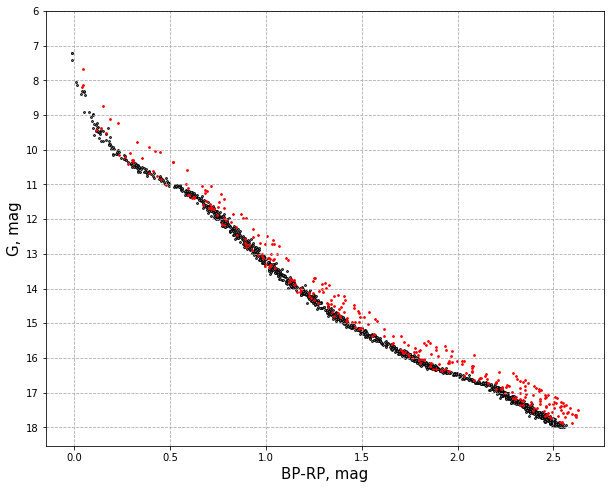

In [152]:
fig, ax = plt.subplots(figsize=(10,8 )) #16:14
ax.scatter (cluster['BP-RP, mag']  +3.1*0.13*(1.2 - 0.65) , cluster['G, mag'] + 5 * np.log10(410) - 5 + 3.1*0.13*0.86,facecolor='white', edgecolor='black', s = 3)
ax.scatter (binaries['BP-RP, mag']  +3.1*0.13*(1.2 - 0.65), binaries['G, mag']  + 5 * np.log10(410) - 5 + 3.1*0.13*0.86, c ='red', s = 3)
ax.invert_yaxis()
ax.grid(c='#aaaaaa', ls='--')
plt.xlabel('BP-RP, mag', size = 15)
plt.yticks(np.arange(6,19, step=1.0))
plt.ylabel('G, mag', size = 15)
plt.savefig(f"NGC2516_model_{in_file_q.split('.')[0]}.png")

In [153]:
binaries.to_csv(f"NGC2516_model_{in_file_q.split('.')[0]}_binaries.txt", sep=';', index=False)
cluster.to_csv(f"NGC2516_model_{in_file_q.split('.')[0]}_singles.txt", sep=';', index=False)